<h1>Mobile Price Classification</h1>
Classifying mobile price-range using ensemble models (RandomForest Classifier , ExtraTrees Classifier <br>and GradientBoosting Classifier) with a model accuracy of 89%.<br>
<br>
<h3>Importing the needed libraries</h3>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline 

from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier , GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report , confusion_matrix , roc_curve , accuracy_score

import time 
import warnings

warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mobile-price-classification/train.csv
/kaggle/input/mobile-price-classification/test.csv


<h2>Exploratory Data Analysis</h2> 

In [2]:
pd.set_option('max_columns' , None)

df = pd.read_csv('../input/mobile-price-classification/train.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
df.shape

(2000, 21)

There are 2000 instances and 20 Independent Features and 1 Dependent Feature ('Price Range'). 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

<b>Looking</b>  at the following output it seems that there are no missing values so we can skip the Data Cleaning process. As concern related to Outliers , we can handle them by hyper-tuning the Parameters of the Ensemble models, example by performing 'Pruning'.

In [5]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


<h1>Data Visualization</h1>

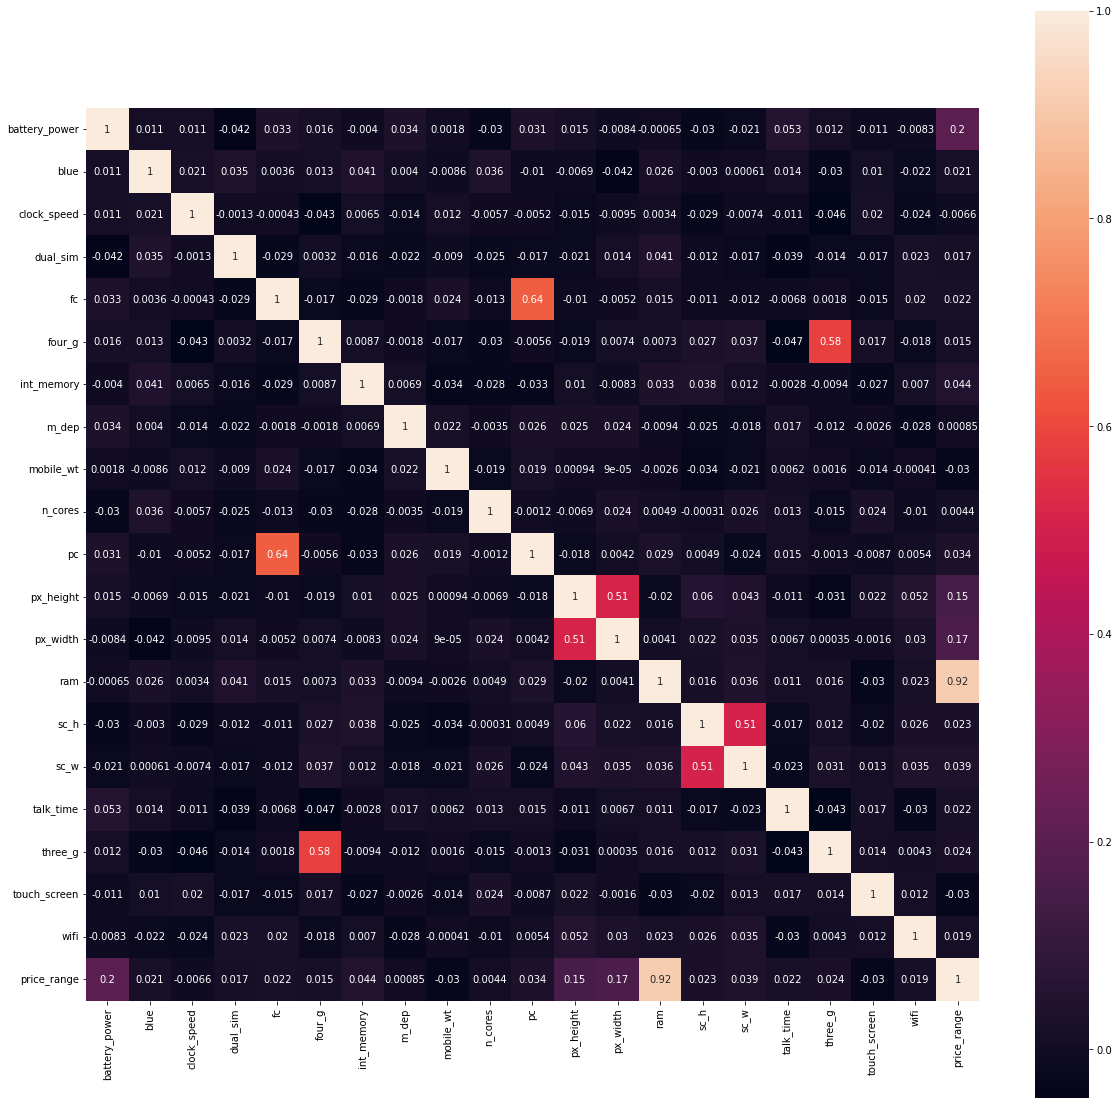

In [6]:
corr_mat = df.corr()
plt.figure(1 , figsize = (20 , 20))
sns.heatmap(data = corr_mat , annot = True , square = True)
plt.show()

<h3>observtion from the heatmap:</h3>
- Independent variable <b>RAM</b> is highly positively correlated to the dependent variable <b>Price Range</b>.<br>
- Variables screen height and width are positively correlated, similary front camera mega pixels and primary camera mega         pixles are correlated and even 4g and 3g , pixel height and pixel width.<br>

<h2><center>Histograms</center></h2>

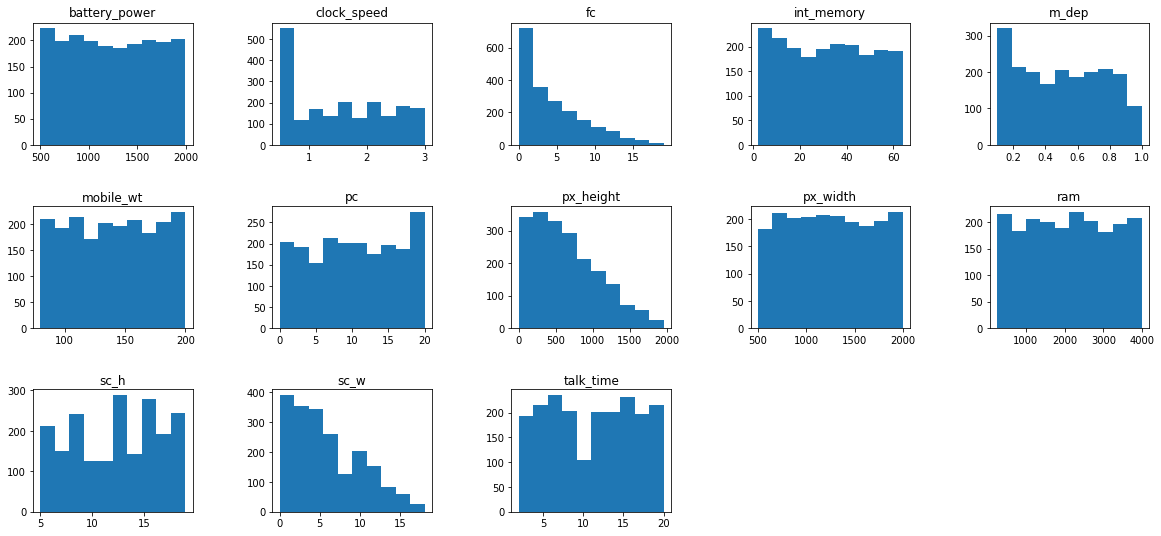

In [7]:
contFeat = ['battery_power' , 'clock_speed' , 'fc' , 'int_memory' , 'm_dep' , 'mobile_wt' , 'pc' ,
            'px_height' , 'px_width' , 'ram' , 'sc_h' , 'sc_w' , 'talk_time']

descreteFeat = ['blue' , 'n_cores' ,'dual_sim' , 'four_g' , 'three_g' , 'touch_screen' , 'wifi' , 'price_range']

plt.figure(1 , figsize = (20 , 9))

n = 0 
for x in contFeat:
    n += 1
    plt.subplot(3 , 5 , n)
    plt.hist(df[x])
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    plt.title('{}'.format(x))

plt.show()

<h2><center>Count Plots or Bar Graph</center></h2>

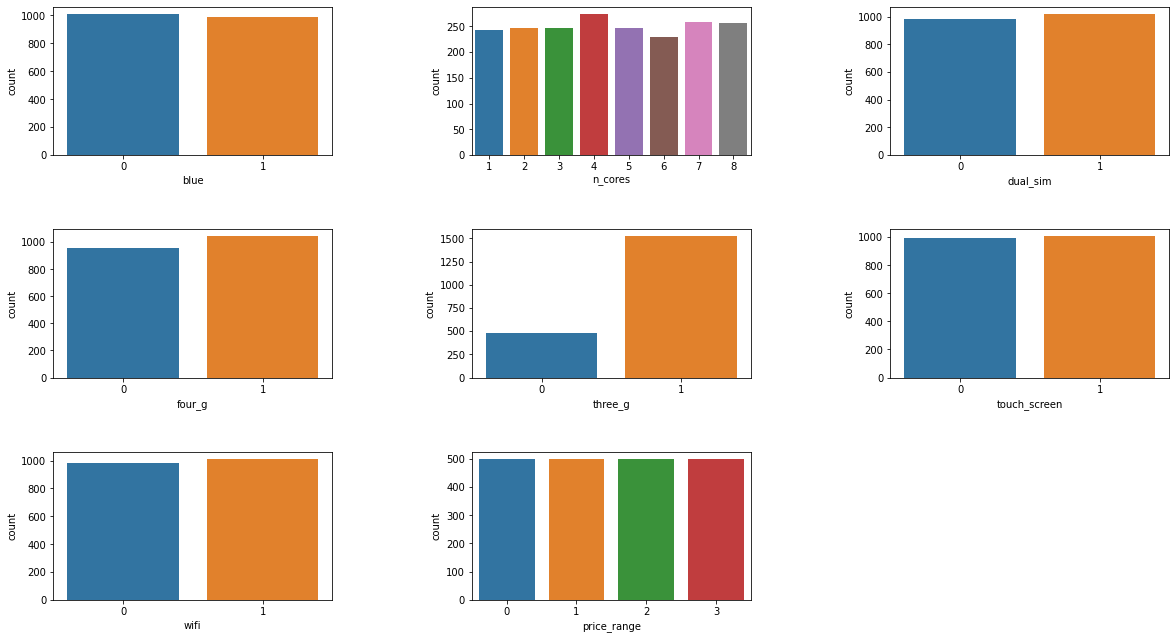

In [8]:
plt.figure(1 , figsize = (20 , 15))

n = 0 
for x in descreteFeat:
    n += 1
    plt.subplot(4 , 3 , n)
    sns.countplot(x = x , data = df)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    
plt.show()

<h2><center>Scatter Plots</center></h2>

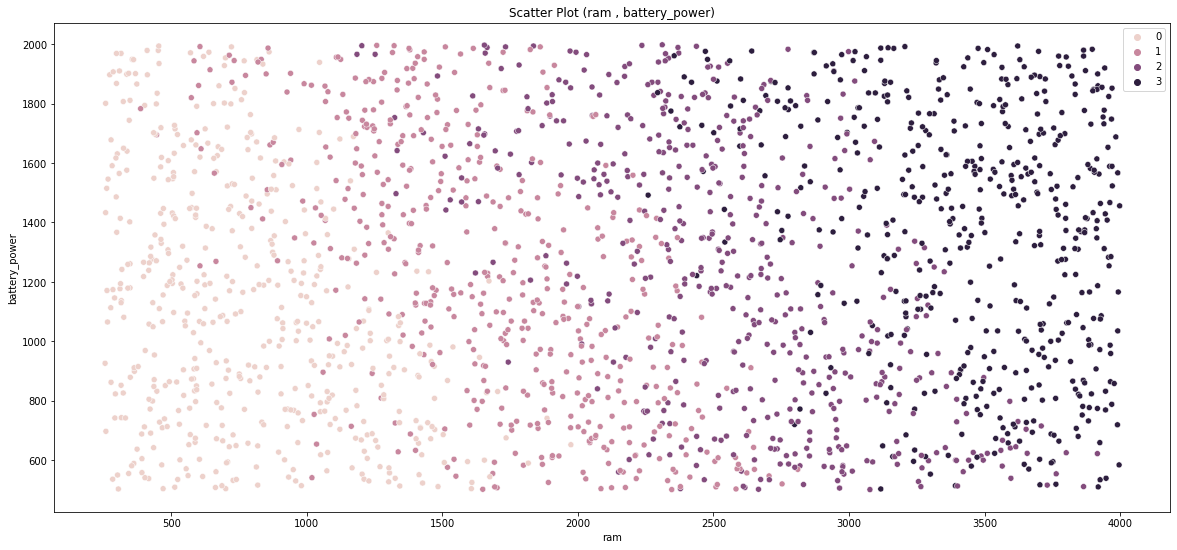

In [9]:
def scatter_plot(x , y , hue , data):
    plt.figure(1 , figsize = (20 , 9))
    sns.scatterplot(x = x , y = y , hue = hue , data = data)
    plt.legend()
    plt.title('Scatter Plot ({} , {})'.format(x , y))
    plt.show()
    
scatter_plot(x = 'ram' , y = 'battery_power' , hue = 'price_range' , data = df)

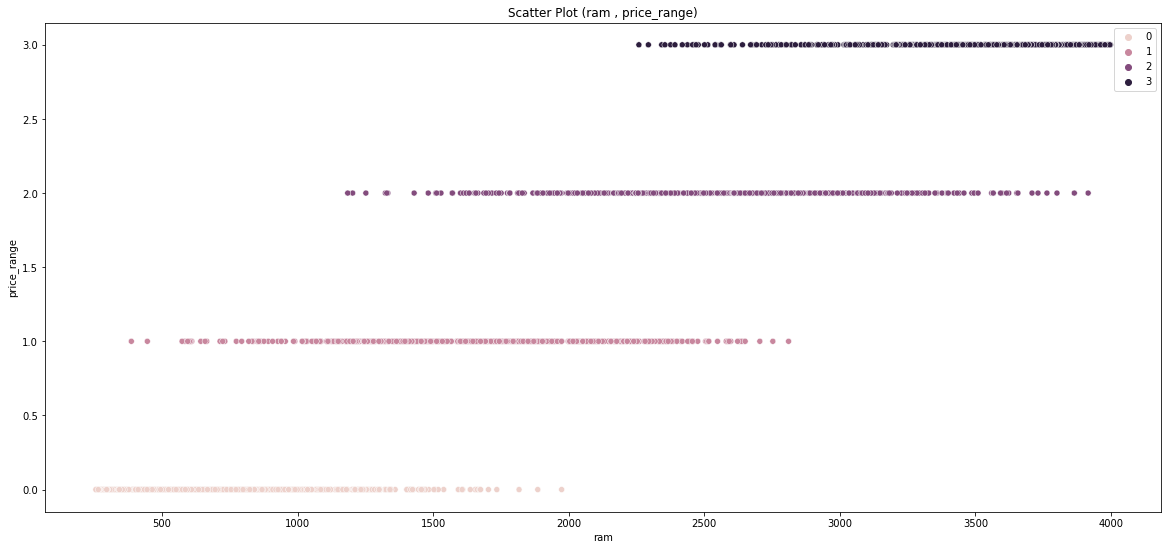

In [10]:
scatter_plot(x = 'ram' , y = 'price_range' , hue = 'price_range' , data = df)

<h3>Observation</h3>
Here we can clearly visualize the relation between RAM and Price Range. as RAM size increases Price of the Mobile Increases.

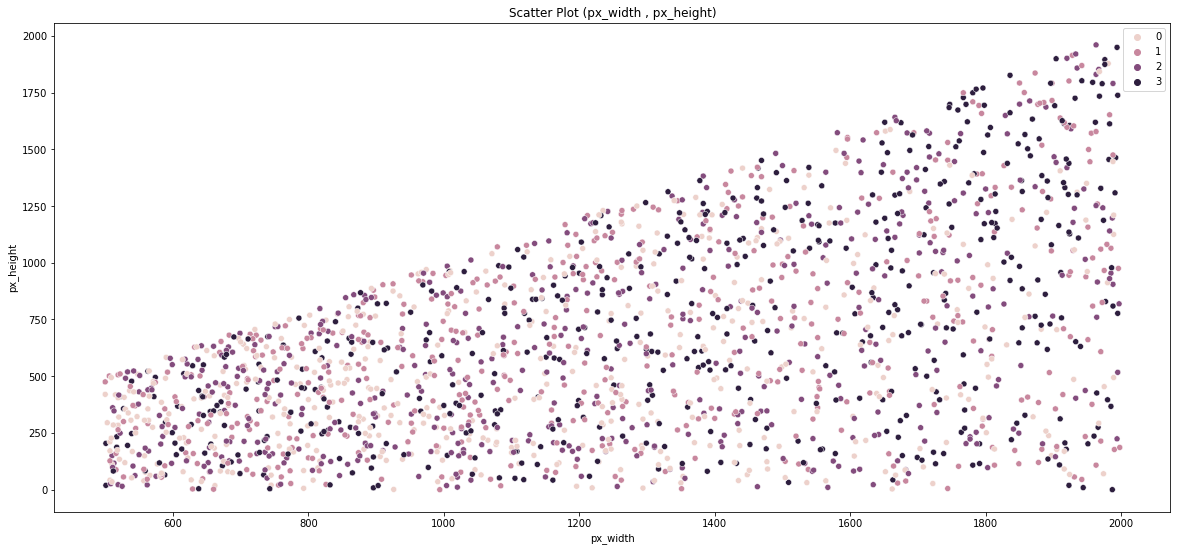

In [11]:
scatter_plot(x = 'px_width' , y = 'px_height' , hue = 'price_range' , data = df)

<h2>Feature Engineering</h2>
- Extracting new Features, more the features the better the model will perform.

In [12]:
'''more the features and data the best the machine will learn'''
df['f1'] = df['sc_w'] * df['sc_h']
df['f2'] = df['n_cores']/df['clock_speed']
df['f3'] = df['battery_power']/df['ram']
df['f4'] = df['sc_w']*df['sc_h']*df['m_dep']
df['f5'] = df['px_height']*df['px_width']

df['f6'] = np.sqrt(df['ram'])
df['f7'] = np.log(df['ram'])

<h2>Data Preprocessing</h2>

In [13]:
X = df.drop( 'price_range' , axis = 1 )
y = df['price_range'].copy()

<b>Splitting</b> the data into Train and Test

In [14]:
xTrain , xTest , yTrain , yTest  = tt(X , y ,
                                      test_size = 0.20 , 
                                      random_state = 20)

<h1>RandomForest Classifier</h1>
- First, create a pipeline where the data first gets scaled and then is fed to the model for training. <br>
- Then we will make a Dictionary of Parameters for hyper-tunning, and we will provide the parameters to Randomized Search       Cross-validation.<br>
- Then we will select the best parameters and use them for training and predicting.<br>
- And finally, we will evaluate the model's performance.

In [15]:
'''rf classifier pipeline'''
randomforestCLF = Pipeline(steps = [('scaler' , StandardScaler()) , 
                                    ('rf' , RandomForestClassifier(criterion = 'entropy' , n_jobs = -1))])

'''parameters'''
parameters_rf = {'rf__n_estimators':[10 , 100 , 250 , 300 , 400 ,  500 , 700],
                 'rf__max_depth' : [ None , 4 , 8  , 10 , 12] , 
                 'rf__max_features' : ['sqrt' , 'log2'] , 
                 'rf__max_leaf_nodes' : [0 , 4 , 8 , 10] ,
                 'rf__max_samples' : [100 , 250 , 500]}

'''cross validation'''
rf_rand_cv = RandomizedSearchCV(randomforestCLF , parameters_rf , cv = 5 , n_iter = 50  , n_jobs = -1 )
rf_rand_cv.fit(xTrain , yTrain)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rf',
                                              RandomForestClassifier(criterion='entropy',
                                                                     n_jobs=-1))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'rf__max_depth': [None, 4, 8, 10, 12],
                                        'rf__max_features': ['sqrt', 'log2'],
                                        'rf__max_leaf_nodes': [0, 4, 8, 10],
                                        'rf__max_samples': [100, 250, 500],
                                        'rf__n_estimators': [10, 100, 250, 300,
                                                             400, 500, 700]})

In [16]:
rf_rand_cv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features='sqrt', max_leaf_nodes=10,
                                        max_samples=500, n_estimators=300,
                                        n_jobs=-1))])

<b>Following</b> are the best suited parameters for the model

<h2>Training and Predicting on train and test data we created.</h2>
- Using the best parameters

In [17]:
timeTaken = []
model_name = []
start = time.time()
randomforestCLF = Pipeline(steps = [('scaler' , StandardScaler()) , 
                                    ('rf' , RandomForestClassifier(n_estimators = rf_rand_cv.best_params_['rf__n_estimators'] , 
                                                                   bootstrap = True ,
                                                                   criterion = 'entropy' ,
                                                                   max_depth = rf_rand_cv.best_params_['rf__max_depth'], 
                                                                   max_features = rf_rand_cv.best_params_['rf__max_features'] ,
                                                                   max_leaf_nodes = rf_rand_cv.best_params_['rf__max_leaf_nodes'] ,
                                                                   max_samples = rf_rand_cv.best_params_['rf__max_samples'] ,
                                                                   n_jobs = -1))])
randomforestCLF.fit(xTrain , yTrain)
yPred_rf = randomforestCLF.predict(xTest)

end = time.time()
timeTaken.append(end - start)
model_name.append('RandomForestClassifier')

<h3>Evaluation</h3>

In [18]:
def Report(ytest , ypred):
    print('Accuracy : {}% \n'.format(accuracy_score(ytest , ypred)*100))
    print('Confusion Matrix : \n\n{}\n'.format(confusion_matrix(ytest , ypred)))
    print('Classification Report : \n\n{}'.format(classification_report(ytest , ypred)))
    
Report(yTest  , yPred_rf)

Accuracy : 80.0% 

Confusion Matrix : 

[[82  6  0  0]
 [11 78  9  0]
 [ 0 31 69 14]
 [ 0  0  9 91]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.88      0.93      0.91        88
           1       0.68      0.80      0.73        98
           2       0.79      0.61      0.69       114
           3       0.87      0.91      0.89       100

    accuracy                           0.80       400
   macro avg       0.80      0.81      0.80       400
weighted avg       0.80      0.80      0.80       400



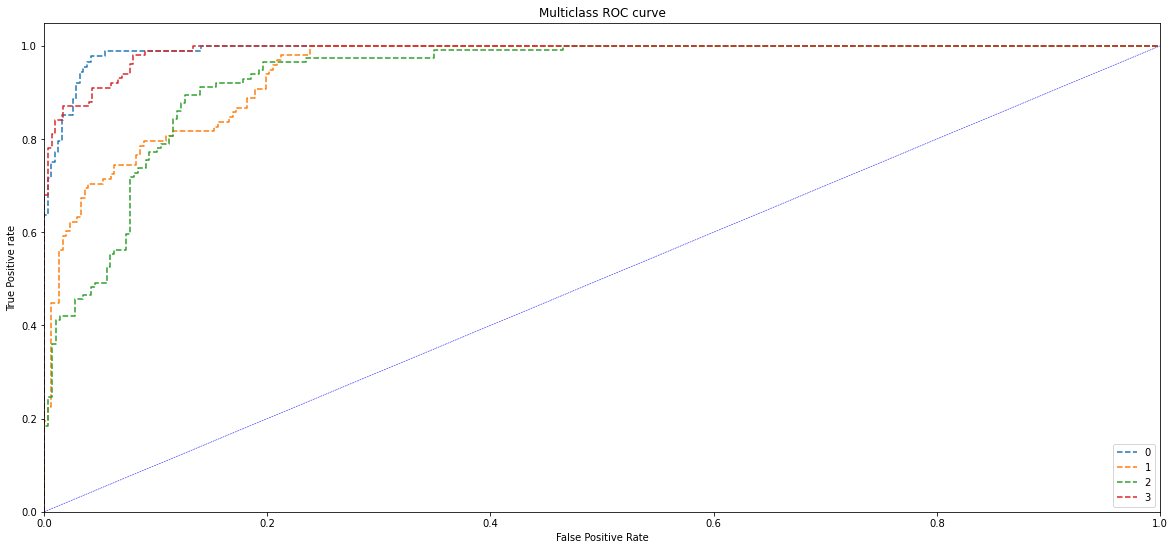

In [19]:
yPred_prob = randomforestCLF.predict_proba(xTest)
def roc_curve_plot(y_actual , y_predicted_probs):
    
    fpr = {}
    tpr = {}
    thres = {}
    roc_auc = dict()

    n_class = y_actual.unique().shape[0]
    y_lb = label_binarize(yTest , classes = np.unique(y_actual))

    plt.figure(1 , figsize = (20 , 9))
    for i in range(n_class):
        
        fpr[i] , tpr[i] , thres[i] = roc_curve(y_lb[: , i] , y_predicted_probs[: , i])
        plt.plot(fpr[i] , tpr[i] , '--' , linewidth = 1.5,  label = '{}'.format(i))
    
    plt.plot([0 , 1] , [0 ,1] , 'b--' , linewidth = 0.5)
    plt.xlim([0 , 1])
    plt.ylim([0 , 1.05])
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='lower right')
    plt.show()
    
roc_curve_plot(yTest , yPred_prob)

<h1>ExtraTrees Classifier</h1>
- We will perform the same process as we performed from RandomForest

In [20]:
'''ExtraTree'''

extraTree_clf = Pipeline(steps = [('scaler' , StandardScaler()) , 
                                  ('et' , ExtraTreesClassifier(criterion = 'entropy' , bootstrap = True , n_jobs = -1))])

parameters_et_clf = {'et__n_estimators' : [300 , 250 , 100  , 650 , 500] ,
                     'et__max_depth' : [2 , 5 , 8 , 10 , 14 , 16] ,
                     'et__max_features' : ['sqrt' , 'log2'] , 
                     'et__max_leaf_nodes' : [None , 1 , 2 , 3 , 4 , 5 , 9] , 
                     'et__max_samples' : [100 , 200 , 300 , 400 , 500 , 750]}

et_clf_randCV = RandomizedSearchCV(extraTree_clf , parameters_et_clf , n_iter = 50 , n_jobs = -1)
et_clf_randCV.fit(xTrain , yTrain )

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('et',
                                              ExtraTreesClassifier(bootstrap=True,
                                                                   criterion='entropy',
                                                                   n_jobs=-1))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'et__max_depth': [2, 5, 8, 10, 14, 16],
                                        'et__max_features': ['sqrt', 'log2'],
                                        'et__max_leaf_nodes': [None, 1, 2, 3, 4,
                                                               5, 9],
                                        'et__max_samples': [100, 200, 300, 400,
                                                            500, 750],
                                        'et__n_estimators': [300, 250, 100, 650,
                                      

In [21]:
et_clf_randCV.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('et',
                 ExtraTreesClassifier(bootstrap=True, criterion='entropy',
                                      max_depth=14, max_features='sqrt',
                                      max_samples=100, n_estimators=500,
                                      n_jobs=-1))])

<h2>Training and Predicting on train and test data we created.</h2>
- Using the best parameters

In [22]:
start = time.time()
extraTree_clf = Pipeline(steps = [('scaler' , StandardScaler()) , 
                                  ('et' , ExtraTreesClassifier(criterion = 'entropy' , bootstrap = True , 
                                                               max_depth = et_clf_randCV.best_params_['et__max_depth'],
                                                               max_features = et_clf_randCV.best_params_['et__max_features'], 
                                                               max_samples = et_clf_randCV.best_params_['et__max_samples'], 
                                                               n_estimators = et_clf_randCV.best_params_['et__n_estimators'] , 
                                                               n_jobs = -1))])

extraTree_clf.fit(xTrain , yTrain)
yPred_et = extraTree_clf.predict(xTest)

end = time.time()

model_name.append('ExtraTrees Classifier')
timeTaken.append(end - start)

yPerd_prob_et = extraTree_clf.predict_proba(xTest)

<h2>Evaluation</h2>

In [23]:
Report(yTest , yPred_et)

Accuracy : 82.0% 

Confusion Matrix : 

[[82  6  0  0]
 [13 76  9  0]
 [ 0 23 81 10]
 [ 0  0 11 89]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.86      0.93      0.90        88
           1       0.72      0.78      0.75        98
           2       0.80      0.71      0.75       114
           3       0.90      0.89      0.89       100

    accuracy                           0.82       400
   macro avg       0.82      0.83      0.82       400
weighted avg       0.82      0.82      0.82       400



<b>ExtraTrees Classifier performed better than Randomforest Classifier.</b>

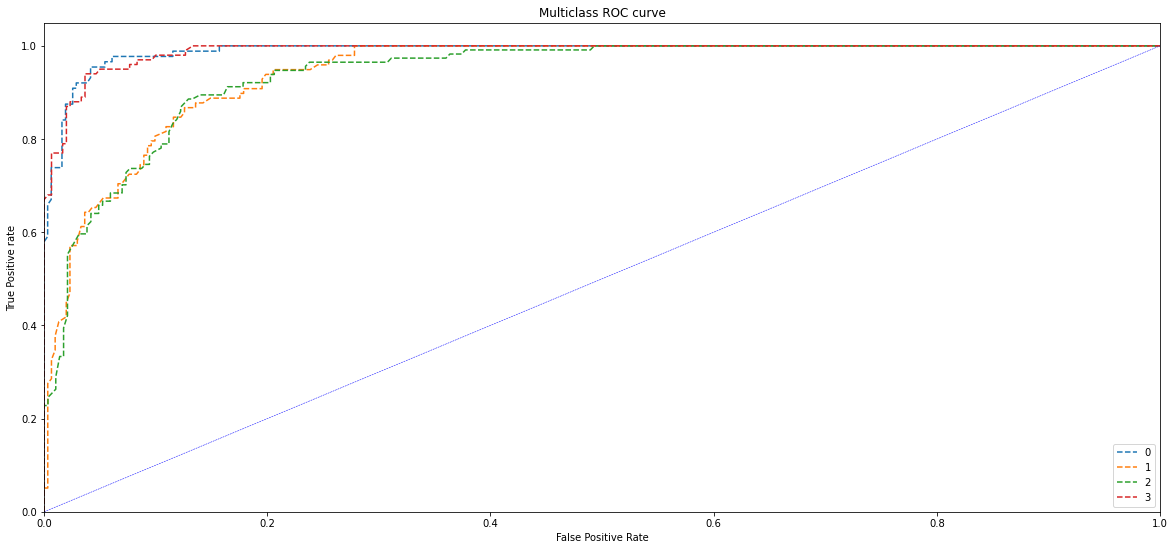

In [24]:
roc_curve_plot(yTest , yPerd_prob_et)

<h1>GradientBoosting Classifier</h1>

In [25]:
'''GradientBoosting'''

gradientB_clf = Pipeline(steps = [('scaler' , StandardScaler()) , 
                                  ('gb' , GradientBoostingClassifier())])

parameters_gb = { 'gb__learning_rate' : [0.01 , 0.001 , 0.1 , 0.5 , 1] , 
                 'gb__n_estimators' : [100 , 200 , 300 , 400 , 500 , 750] , 
                 'gb__subsample' : [0.5 , 0.1 , 1.0] , 
                 'gb__criterion' : ['friedman_mse'] , 
                 'gb__max_depth' : [1 , 2 , 5 , 7 , 10 , 15] , 
                 'gb__max_features' : ['sqrt' , 'log2' , 2 , 5] , 
                 'gb__max_leaf_nodes' : [None , 2 , 3 , 5 , 6 , 7 , 8 , 9 , 10]}

gb_clf_randCV = RandomizedSearchCV(gradientB_clf , parameters_gb , n_iter = 50 , n_jobs = -1)
gb_clf_randCV.fit(xTrain , yTrain)

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('gb',
                                              GradientBoostingClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'gb__criterion': ['friedman_mse'],
                                        'gb__learning_rate': [0.01, 0.001, 0.1,
                                                              0.5, 1],
                                        'gb__max_depth': [1, 2, 5, 7, 10, 15],
                                        'gb__max_features': ['sqrt', 'log2', 2,
                                                             5],
                                        'gb__max_leaf_nodes': [None, 2, 3, 5, 6,
                                                               7, 8, 9, 10],
                                        'gb__n_estimators': [100, 200, 300, 400,
                                                             500

In [26]:
gb_clf_randCV.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('gb',
                 GradientBoostingClassifier(learning_rate=1, max_depth=15,
                                            max_features=5, max_leaf_nodes=5,
                                            n_estimators=200))])

<h2>Training and Predicting on train and test data we created.</h2>
- Using the best parameters

In [27]:
start = time.time()

gradientB_clf = Pipeline(steps = [('scaler' , StandardScaler()) , 
                                  ('gb' , GradientBoostingClassifier(learning_rate = gb_clf_randCV.best_params_['gb__learning_rate'], 
                                                                     max_depth = gb_clf_randCV.best_params_['gb__max_depth'], 
                                                                     max_features = gb_clf_randCV.best_params_['gb__max_features'],
                                                                     max_leaf_nodes = gb_clf_randCV.best_params_['gb__max_leaf_nodes'], 
                                                                     n_estimators = gb_clf_randCV.best_params_['gb__n_estimators']))])

gradientB_clf.fit(xTrain , yTrain)
yPred_gb = gradientB_clf.predict(xTest)

end = time.time()
timeTaken.append(end- start)
model_name.append('GradientBoosting Classifier')

yPred_prob_gb = gradientB_clf.predict_proba(xTest)

<h2>Evaluation</h2>

In [28]:
Report(yTest , yPred_gb)

Accuracy : 90.0% 

Confusion Matrix : 

[[83  5  0  0]
 [ 6 88  4  0]
 [ 0  8 99  7]
 [ 0  0 10 90]]

Classification Report : 

              precision    recall  f1-score   support

           0       0.93      0.94      0.94        88
           1       0.87      0.90      0.88        98
           2       0.88      0.87      0.87       114
           3       0.93      0.90      0.91       100

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



<b>GradientBoosting Classifier</b> outperformed both the classifiers. The recall and precision scores for all the classes are descent we can use this classifier to predict on the test dataset

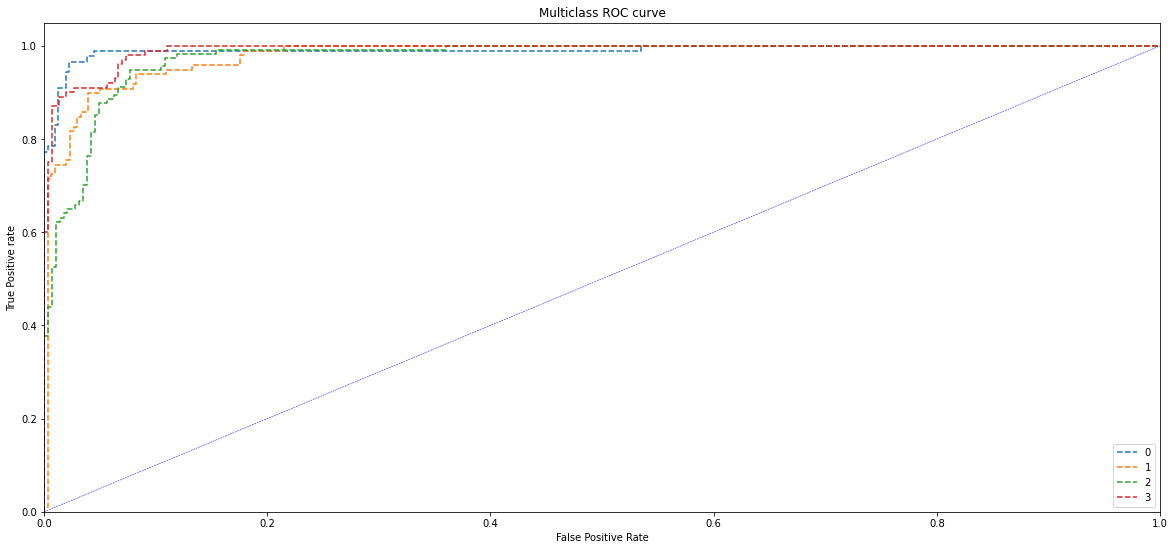

In [29]:
roc_curve_plot(yTest , yPred_prob_gb)

<h1> Performance</h1>

In [30]:
acc = [accuracy_score(yTest , yPred_rf) , accuracy_score(yTest , yPred_et) , accuracy_score(yTest , yPred_gb)]
perf = {'model' : model_name , 'acc' : acc , 'run_time' : timeTaken}

model_perf = pd.DataFrame(data = perf)
model_perf

,model,acc,run_time
0,RandomForestClassifier,0.80,0.923217
1,ExtraTrees Classifier,0.82,1.402506
2,GradientBoosting Classifier,0.90,1.582902


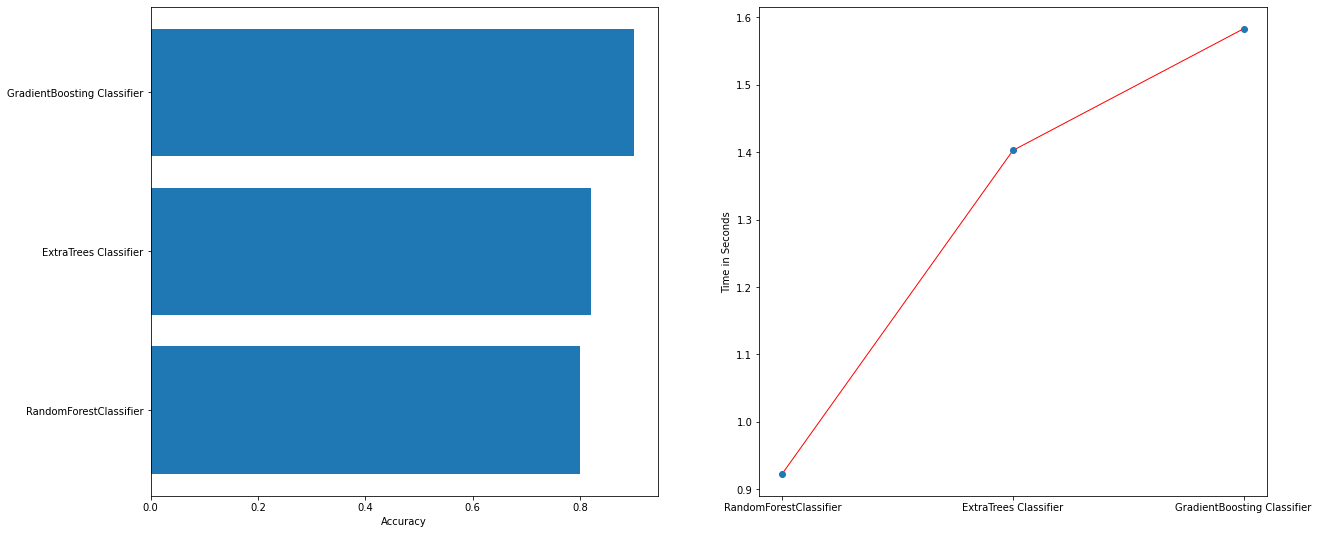

In [31]:
plt.figure(1 , figsize = (20 , 9))

plt.subplot(1 , 2 , 1)
plt.barh(model_perf['model'] , model_perf['acc'])
plt.xlabel('Accuracy')

plt.subplot(1 , 2 , 2)

plt.plot(model_perf['model'] , model_perf['run_time'] , 'r-' , linewidth = 1)
plt.plot(model_perf['model'] , model_perf['run_time'] , 'o')

plt.ylabel('Time in Seconds')
plt.show()

<h1>Prediction on Unseen Data</h1>

In [32]:
df_test = pd.read_csv('../input/mobile-price-classification/test.csv')
df_test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


In [33]:
'''adding the new features'''
df_test['f1'] = df_test['sc_w'] * df_test['sc_h']
df_test['f2'] = df_test['n_cores']/df_test['clock_speed']
df_test['f3'] = df_test['battery_power']/df_test['ram']
df_test['f4'] = df_test['sc_w']*df_test['sc_h']*df_test['m_dep']
df_test['f5'] = df_test['px_height']*df_test['px_width']

df_test['f6'] = np.sqrt(df_test['ram'])
df_test['f7'] = np.log(df_test['ram'])

df_test.drop('id' , axis = 1 , inplace = True)
df_test.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,f1,f2,f3,f4,f5,f6,f7
0,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0,84,1.666667,0.300058,8.4,319112,58.957612,8.153637
1,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0,0,10.000000,0.215918,0.0,639322,62.409935,8.267449
2,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1,170,1.071429,0.754174,153.0,1734820,48.948953,7.781556
3,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0,0,16.000000,0.397123,0.0,516840,62.393910,8.266935
4,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1,120,4.285714,0.808799,60.0,606690,42.107007,7.480428


<h2>Predicting using GradientBoosting Classifier</h2>

In [34]:
predicted = gradientB_clf.predict(df_test)
df_test['predicted_price_range'] = predicted

<h2><center>Plotting the Predicted Price Range</center></h2>

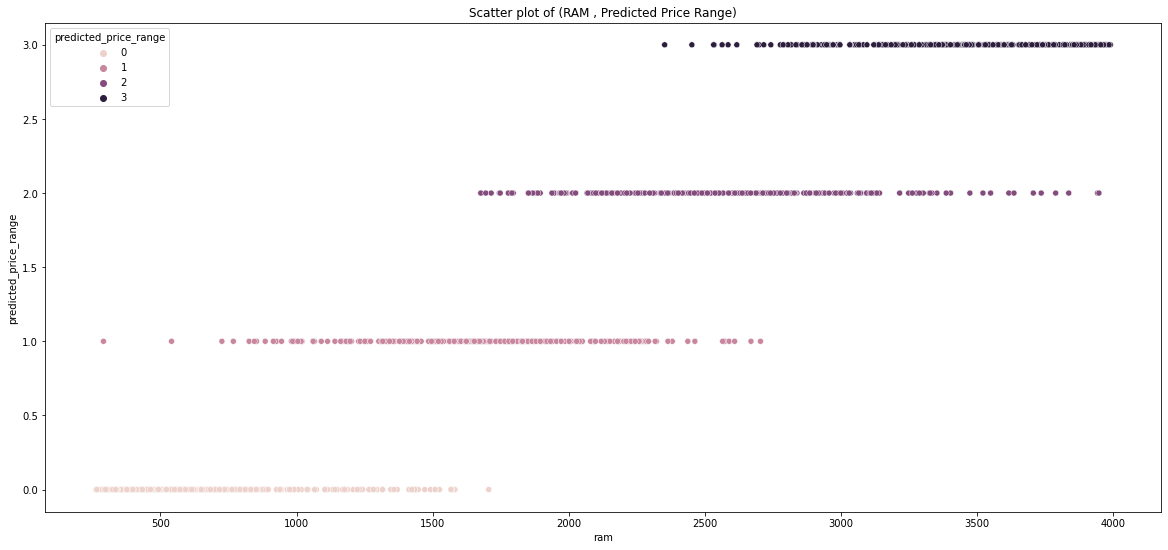

In [35]:
plt.figure(1 , figsize = (20 , 9))

sns.scatterplot(df_test['ram'] , df_test['predicted_price_range'] , hue = df_test['predicted_price_range'])
plt.title('Scatter plot of ({} , {})'.format('RAM','Predicted Price Range'))
plt.show()

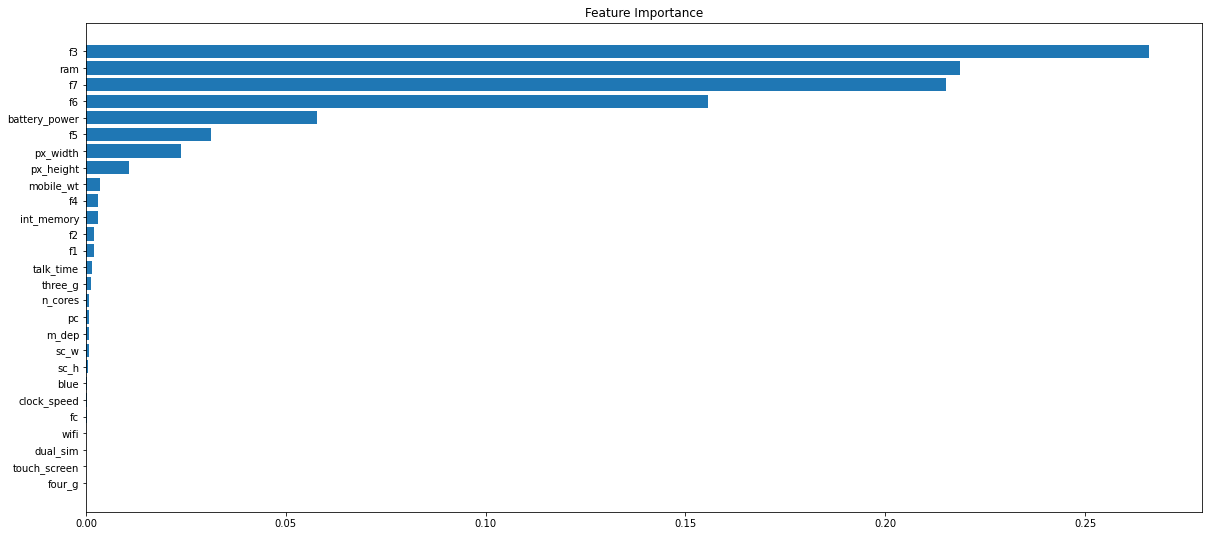

In [36]:
imp_feature = {'features' : df_test.iloc[:,:-1].columns.tolist() , 'importance' : gradientB_clf.steps[1][1].feature_importances_.tolist()}
imp = pd.DataFrame(imp_feature)
imp = imp.sort_values('importance' , ascending = True)
plt.figure(1 , figsize = (20 , 9) )
plt.barh(imp['features'] , imp['importance'])
plt.title('Feature Importance')
plt.show()

<h2><center>THANK YOU!</center></h2>